# Exploring Qiskit in the context of numerical computation

This project would explore IBM's Qiskit package and how we can use numerical computation techniques for quantum computation. I seek first to explain this package and then motivate the application of numerical computation to quantum computing. 

### What is quantum computing?
Without exploring the underlying physics, we can explain the difference between classical computing and quantum computing by understanding bits and qbits as mathematical objects with differing limits.

Let us assume that we have both $n$ bits and $n$ qbits. We can think of an $n$ bit classical value as an $n$ dimensional vector who's values can only be $0$ or $1$. Likewise, we can think of an $n$ qbit quantum value as an $2^n$ dimensional vector that is limited to a unit vector. 

For a 2 bit classical system, there are 4 possible vectors: $$\begin{bmatrix}0\\0\end{bmatrix},\begin{bmatrix}1\\0\end{bmatrix},\begin{bmatrix}0\\1\end{bmatrix},\begin{bmatrix}1\\1\end{bmatrix}$$

For a 2 bit quantum system, there are infinitely many vectors $$v = \begin{bmatrix}\alpha\\\beta\\\gamma\\\delta\end{bmatrix} \in \mathbb{C}^4 , v^\dagger v = 1$$

Another key difference between quantum and classical computing, is what happens when we query the state of a bit vector. In classical computing, querying the state of a bit string does not change the state of the string. However, querying (or measuring) the state of a qbit string collapses it's state to one of the standard basis vectors. The probability of this collapse is the square of the value on that row. In otherwords, for basis vector $e_n$ the probability of that measurement is $|e_n^T v|^2$

Many quantum computation algorithms are formulated around modifying the probabilities of measuring a certain result such that the most likely result gives useful information in the efforts of solving a problem. Ideally this probability is 100%, but some algorithms can only provide a high likelyhood of measuring the correct answer.

Akin to how classical computers, at their lowest level, perform algorithms (even ones as simple as addition) by passing bit values through simple logic gates, quantum computers perform algorithms by passing qbit values through simple quantum logic gates.

### What does qiskit *do*?

The qiskit package helps implement quantum algorithms in two ways. Firstly, qiskit allows us to design quantum circuits by defining a series of quantum gates. Qiskit can then display this design using quantum circuit symbols. Below is a simple example of a quantum circuit built using qiskit

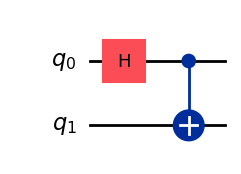

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

In [2]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

management.get:WARNING:2025-10-19 17:00:48,046: Loading saved account: open


qiskit_runtime_service.__init__:WARNING:2025-10-19 17:01:00,250: Instance was not set at service instantiation. Free and trial plan instances will be prioritized. Based on the following filters: (tags: None, region: us-east, eu-de), and available plans: (open), the available account instances are: Numerical Computation. If you need a specific instance set it explicitly either by using a saved account with a saved default instance or passing it in directly to QiskitRuntimeService().
qiskit_runtime_service.backends:WARNING:2025-10-19 17:01:00,446: Loading instance: Numerical Computation, plan: open
qiskit_runtime_service.backends:WARNING:2025-10-19 17:01:01,756: Using instance: Numerical Computation, plan: open


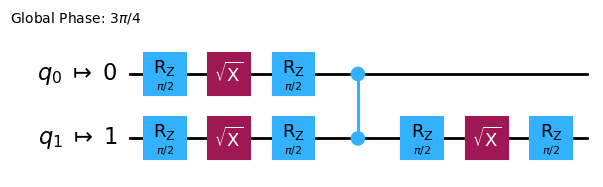

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService(name="open")
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

Qiskit also allows us to submit quantum algorithms to be run on actual quantum computers using IBM's cloud computing services.

In [4]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d3qmrcbgrqts7385h05g


In [5]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

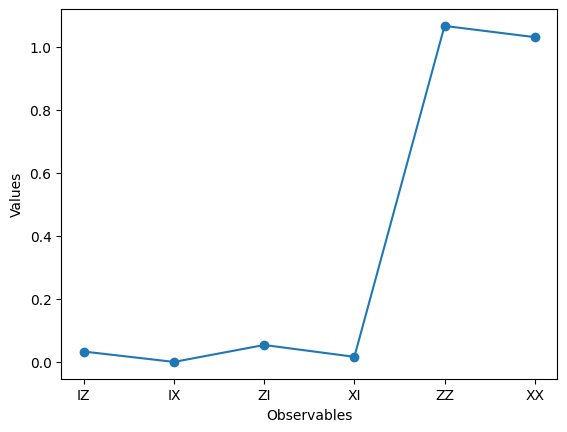

In [6]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

We notice that for qbits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (XX and ZZ) are 1. This is a hallmark of quantum entanglement! Why this is, while not relevant, is fun to observe from a real quantum computer. The point is, qiskit allowed us to assemble a quantum circuit and run it on a real computer! 

But how does this relate to numerical computation? We can use numerical computation techniques to synthesize quantum circuits!

### Using Householder transformations to break down a matrix operation $A$ into a series of basic quantum gates

Quantum computing often uses a unique representation of vectors using what is called bra-ket notation, where the basis states are represented as $\ket{0} = \begin{bmatrix}1\\0\end{bmatrix}$ and $\ket{1} = \begin{bmatrix}0\\1\end{bmatrix}$.

For higher qbit systems, the representation is simplified as follows $$\ket{01} = \ket{0}\ket{1} = \begin{bmatrix}0\\1\\0\\0\end{bmatrix}$$

As a matter of convention, we tend to represent qbit states as linear sums of these basis states. For example
$$\begin{bmatrix}\frac{1}{\sqrt{2}}\\\frac{1}{\sqrt{2}}\end{bmatrix}=\frac{1}{\sqrt{2}}(\ket{0}+\ket{1})$$

Finally, the bra part of bra-ket notation is a useful shorthand for transposes. $\bra{\psi}=\ket{\psi}^T$

In quantum computing, a program can be represented as a matrix multiplication (or series of matrix multiplications) acting on a starting quantum state (typically the initial state is a column of the identity matrix)

Recall in our householder algorithm we construct $Q_n\cdots Q_1 A=R$. The algorithm used to produce quantum circuits takes advantage of the fact that quantum operators reqiuire $A$ to be a unitary matrix and this makes QR factorization consist of progressively diagonalizing $A$.

In their paper ["Quantum circuits synthesis using Householder
transformations"](https://arxiv.org/pdf/2004.07710), Goubault de Brugière, Baboulin, Valiron, and Allouche, claim that in the special case of $A$ being a unitary matrix, we can say $$(HA)_{k:n,k:n} = A_{k:n,k:n}-u(k:n)\cdot r(k:n)$$ Then, if we have already factorized the first $nb$ rows and columns such that the first $nb$ columns of an updated in place $A$ matrix contains the householder vectors and we can update the matrix by setting $$A(nb+1:n,nb+1:n)\leftarrow A(nb+1:n,nb+1:n)-A(nb+1:n,1:nb)\times A(1:nb,nb+1:n)$$ and that this operation is a BLAS 3 operation. They also claim that we can, instead of updating the whole matrix each time, we can update one row and one column each time. "Such updates
consist in more and bigger matrix-vector operations and experimentally it appears to scale
better"

Finally, with the context fully set, the goal of this project would be to experimentally measure the performance of their naive algorithm as it scales and the performance of their improved algorithm as it scales. Then, show that the improved algorithm scales better than the naive algorithm.